In [1]:
from model import *
from data import *

import glob
import cv2

import tensorflow as tf
from tensorflow.metrics import *

from keras.metrics import *
import keras.backend as K

from matplotlib import pyplot as plt

Using TensorFlow backend.


# Load model

In [2]:
model = unet_modify()
model.load_weights('./models/Unet.104-0.99_b.hdf5')

/home/dmitrii/.virtenvs/FaceIidentification/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/dmitrii/sky_detect/Semantic-Segmentation-Suite/UNET/sky-segmentation/keras_unet/model.py:79: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


# Prepare image to use with net

In [3]:
image = cv2.imread('./data/sky/iphone_full/val/IMG_8670.jpg')
image = cv2.cvtColor(image, code=cv2.COLOR_BGR2RGB) 

img = image / 255.
img = cv2.resize(img, (256, 256))
img = np.expand_dims(img, 0)

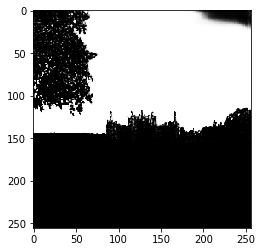

In [4]:
pred_mask = model.predict(img)[0, :, :, 0]

plt.imshow(pred_mask, 'gray')

# Scale values of each pixel of predicted mask to 0..255 interval

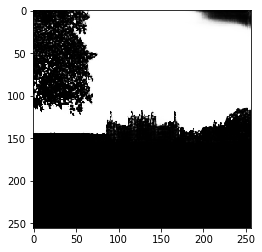

In [5]:
norm_mask = cv2.normalize(pred_mask, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)

plt.imshow(norm_mask, 'gray')

# Apply Otsu threshold to normalized mask 

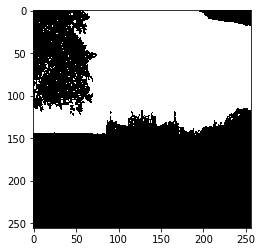

In [6]:
_,thresh = cv2.threshold(norm_mask.copy(), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(thresh, 'gray')

# Fill blob in mask by using contours

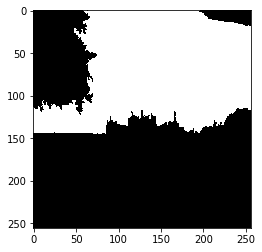

In [7]:
_, contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_list = []
area_threshold = 500

for contour in contours:
    area = cv2.contourArea(contour)
    if area > area_threshold :
        contour_list.append(contour)
        
countMask = np.zeros(thresh.shape, dtype='uint8')
cv2.drawContours(countMask, contour_list, -1, (255, 255, 255), cv2.FILLED)

plt.imshow(countMask, 'gray')

# Increase accuracy of border between sky and other object after filling

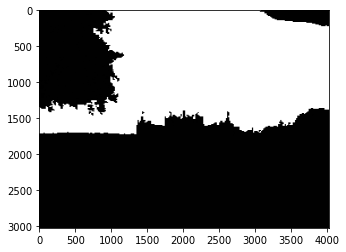

In [8]:
res_mask = cv2.bitwise_not(np.add(cv2.bitwise_not(thresh), cv2.bitwise_not(countMask)))

res_mask = cv2.resize(res_mask, (image.shape[1], image.shape[0]))

plt.imshow(res_mask, 'gray')

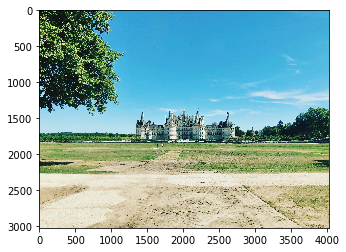

In [9]:
plt.imshow(image, 'gray')

# Sandbox

In [10]:
sandbox_mask = res_mask.copy()